In [1]:
from fastai.vision import *
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

In [3]:
# path = '/home/anand/Data/gastro/train/'
print('Is GPU available?:',torch.cuda.is_available())

Is GPU available?: True


In [4]:
path = Path('/home/anand/Data/mss-msi/')

In [6]:
data = ImageDataLoaders.from_folder(path, train='train', valid='val',size=224, bs=64, num_workers=16)

In [8]:
learn = cnn_learner(data, resnet34, metrics = error_rate)
learn.fit_one_cycle(7)

/home/anand/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,0.445140,0.424839,0.196568,08:28
1,0.349859,0.307140,0.133385,20:09
2,0.284327,0.263980,0.114041,15:34
3,0.261462,0.237200,0.101040,08:20
4,0.235418,0.214391,0.088092,08:21
5,0.215886,0.201764,0.083151,08:24
6,0.214825,0.199836,0.082527,08:25


In [9]:
# Save the model
learn.save('stage-1')

Path('/home/anand/Data/mss-msi/models/stage-1.pth')

In [16]:
# Load the Model
mdl = learn.load('stage-1')

SuggestedLRs(valley=tensor(4.3652e-05))

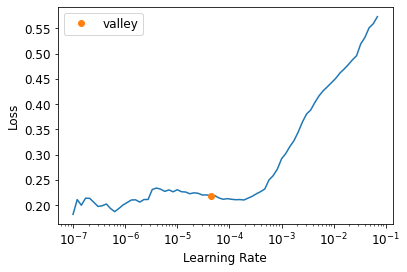

In [18]:
mdl.unfreeze()
mdl.lr_find()

In [22]:
# validation accuracy of the initial model
preds, y, loss = mdl.get_preds(with_loss=True)
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc*100))

The accuracy is 91.74726867675781 %.


ROC area is 0.9740733251055906


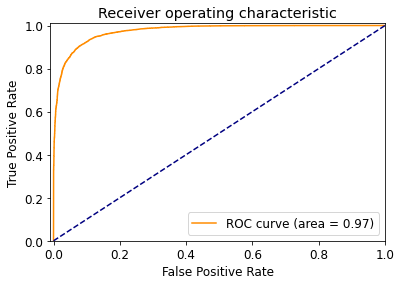

In [24]:
# This Validation-ROC is for the intial model
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [25]:
# Fine tune over 3 epochs using lr.find()
mdl.fit_one_cycle(3, lr_max = slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.276382,0.285522,0.116277,11:14
1,0.162001,0.148340,0.061102,11:19
2,0.093041,0.103950,0.042746,11:17


In [26]:
# Save the model
mdl.save('stage-2')

Path('/home/anand/Data/mss-msi/models/stage-2.pth')

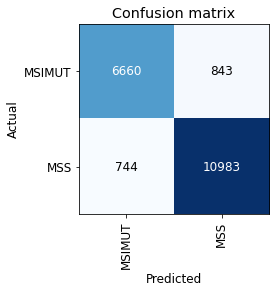

In [27]:
# stage-1 confusion matrix
# Load the Model
model = learn.load('stage-1')
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

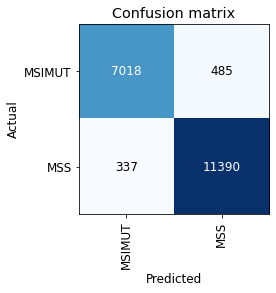

In [28]:
# stage-2 confusion matrix
# Load the Model
new_model = mdl.load('stage-2')
interp = ClassificationInterpretation.from_learner(new_model)
interp.plot_confusion_matrix()

In [29]:
mdl.export()
# path.ls(file_exts='.pkl')

The accuracy is 95.72542572021484 %.
ROC area is 0.9930483052508224


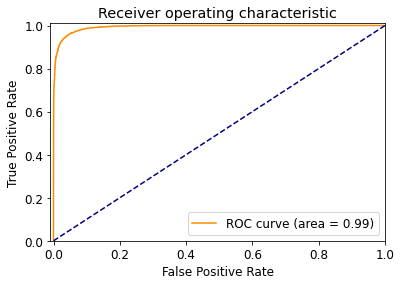

In [31]:
# This validation-ROC is for the fine-tuned model

preds, y, loss = new_model.get_preds(with_loss=True)
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc*100))
from sklearn.metrics import roc_curve, auc

# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [40]:
test_path='/home/anand/Data/mss-msi/test/'
test_files = get_image_files(test_path)
# test_dl = dls.test_dl(test_files)
test_dl = new_model.dls.test_dl(test_files, with_label=True)

In [80]:
pred_probas, _, pred_classes = new_model.get_preds(dl=test_dl, with_decoded=True) 

In [81]:
print(type(pred_probas),type(pred_classes))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [82]:
# Converted to numpy array
import numpy as np
preds = np.round(pred_probas,0)
preds = preds.numpy()
pred_classes = pred_classes.numpy()

In [83]:
print(type(pred_probas),type(pred_classes))

<class 'torch.Tensor'> <class 'numpy.ndarray'>


ROC area is 1.0


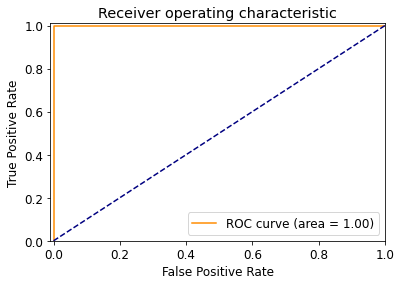

In [84]:
# test ROC for the fine tuned model

from sklearn.metrics import roc_curve, auc

# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(pred_classes, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

